In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

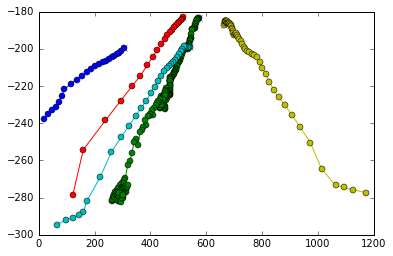

In [4]:
def displayTracks(tracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        track = np.array(tracks.items()[i][1])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o")
displayTracks(tracks, 5)

In [5]:
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [6]:
np.random.seed(7)

In [45]:
def buildLookbackDataset(tracks, lookback=3):
    lookback +=1
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            dataset.append(np.array(track[i-lookback:i]).ravel())
    return dataset
                
dataset = buildLookbackDataset(tracks) 
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [46]:
# Ignore for now
# dset = np.zeros((25002,8))
# for i in xrange(25002):
#     dset[i,:] = dataset[i]

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [48]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(16751, 8251)


In [49]:
xtrain = np.matrix(train[:,0:6])
ytrain = np.matrix(train[:,6:])
xtest = np.matrix(test[:,0:6])
ytest = np.matrix(test[:,6:])

In [52]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 3, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 3, 2))

In [62]:
xtrain[0].shape


(3, 2)

In [66]:
model = Sequential()
model.add(LSTM(4, input_shape=(3,2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(xtrain, ytrain, nb_epoch=10, batch_size=1, verbose=2)

Epoch 1/10
17s - loss: 0.0041
Epoch 2/10
19s - loss: 3.0585e-04
Epoch 3/10
17s - loss: 1.5302e-04
Epoch 4/10
17s - loss: 1.0817e-04
Epoch 5/10
18s - loss: 9.1996e-05
Epoch 6/10
17s - loss: 8.0862e-05
Epoch 7/10
17s - loss: 7.6872e-05
Epoch 8/10
18s - loss: 7.4311e-05
Epoch 9/10
18s - loss: 7.3092e-05
Epoch 10/10
19s - loss: 7.0991e-05


In [67]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 0.0078864 RMSE
Test Score: 0.0070325 RMSE


In [15]:
def rebuildTracks(xtrain, ytrain, xtest, ytest, trainPredict, testPredict, tracks):
    rawdata = []
    predictions = []
    trainindex = 0
    testindex = 0
    for track in tracks.items():
        sample = []
        prediction = []
        for i, pos in enumerate(track):
            if trainindex >= len(xtrain)-1:
                x = xtrain
                y = ytrain
                pred = trainPredict
                index = trainindex
            else:
                x = xtest
                y = ytest
                pred = testPredict
                index = testindex
            if i == 1:
                prediction.append(x[index])
                prediction.append(pred[index])
            if i == len(track)-1:
                sample.append(x[index])
                sample.append(y[index])
            else:
                sample.append(x[index])
                prediction.append(pred[index])
            if trainindex >= len(xtrain)-1:
                trainindex += 1
            else:
                testindex += 1
        rawdata.append(sample)
        predictions.append(prediction)
    return rawdata, predictions

In [16]:
rawdata, predictions = rebuildTracks(xtrain, ytrain, xtest, ytest, trainPredict, testPredict, tracks)

In [17]:
print model.predict(np.array(tracks.items()[0][1][0]).reshape(1,1,2))
print tracks.items()[0][1][0]
print tracks.items()[0][1][1]

[[ 1.42803276  0.68568146]]
[777.654416, 165.681078]
[781.156791, 165.186175]


In [18]:
print np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]).reshape(1,-1)
l = scaler.transform(np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]).reshape(1,-1))
#x = l[0:2].reshape(1,1,2)
#y = l[2:]

[[ 777.654416  165.681078  781.156791  165.186175]]


In [43]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i == 0:
                t.append(pos)
            else:
                # scale and resize
                p = track[1][i-1]
                p = scaler.transform(np.array(p+p).reshape(1,-1))[0][0:2].reshape(1,1,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]).reshape(1,-1))[0][0:2]
                t.append(pred)
    return predTracks

In [44]:
predictedTracks = rebuildTracks(tracks,model)

In [60]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


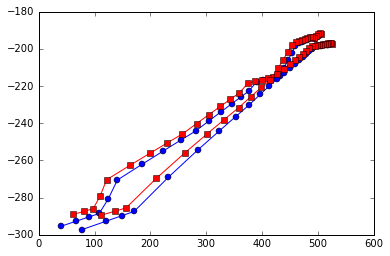

In [70]:
displayPredictedTracks(tracks,predictedTracks, 2)